# Introduction

In this notebook, we retrieve discussion paragraphs given results paragraphs. First, we do a 'withall' search, which means we search for the discussion paragraphs from all 100 papers. Second, we do a 'within' search, meaning we search for the discussion paragraphs from the current paper. Obviously, 'within' would yield better results. For detailed explanation, please refer to NLP_final_report.pdf.


#Importing necessary libraries and packages

In [ ]:
import numpy as np
import os
import shelve
from tqdm import tqdm
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
import sys

In [ ]:
!pip install rank_bm25

In [ ]:
## Install sent2vec
## Installing sent2vec
!git clone https://github.com/epfml/sent2vec.git
!cd sent2vec &&  make && pip install . 

Cloning into 'sent2vec'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 393 (delta 8), reused 9 (delta 3), pack-reused 368
Receiving objects: 100% (393/393), 458.67 KiB | 10.67 MiB/s, done.
Resolving deltas: 100% (236/236), done.
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/args.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/dictionary.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/productquantizer.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/matrix.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/shmem_matrix.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/qmatrix.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/vector.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/model.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/utils.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/fasttext.cc
c++ -pthread -std=c++0x -O3 -funroll-loops args.

In [ ]:
## This is a sent2vec model of 8GB.
## You can download it and copy it using the link https://drive.google.com/file/d/1qcXyNHtT8PAUG4MXDgr3P3uM2598wToU/view?usp=sharing
## to '/content'.
!cp '/content/drive/Shared drives/NeuralSystems_NLP/sent2vec_pubmed_400_original.bin' '/content'

In [ ]:
## Load the sent2vec model into RAM
import sent2vec
model = sent2vec.Sent2vecModel()
model.load_model( "sent2vec_pubmed_400_original.bin" )

#Defining methods

##Class : SearchEngine

In [ ]:
##input data as a dataframe
class SearchEngine:
  def __init__(self):
    pass
  

  # def clean_data(self, doc_id_name, query_name, doc_name):
  #   '''
  #   output : numpy array
  #   '''
  #   ### clean original dataset (''s and Na s)
  #   my_df = self.df[[doc_id_name, query_name, doc_name]]
  #   my_df = my_df[(my_df[query_name]!='') & (my_df[doc_name]!='')]
  #   my_df = my_df.dropna()
  #   ### get a ndarray for my_df
  #   ds = [  [doc_id, query, doc ]   for doc_id, query, doc  in zip( my_df[doc_id_name], my_df[query_name], my_df[doc_name] )]
  #   ds = np.array(ds)
  #   return ds

  def preprocess(self, ds, discussions, full_corpus):  ##for lowercasing
    import nltk
    from nltk import RegexpTokenizer
    # This tokenizer is simply to use a regular expression "\w+" to remove all characters which are not from the set [0-9A-Za-z]
    # This is not the best one but is very fast. Explore the nltk package for more powerful tokenizer!
    tokenizer = RegexpTokenizer( "\w+" )

    # Use this tokenizer to tokenize the dataset we just created.
    #record[0] is document id
    for record in ds:
      record[1] = " ".join(tokenizer.tokenize( record[1].lower()  ))

    for record in discussions:
      record[1] = " ".join(tokenizer.tokenize( record[1].lower()  ))

    for record in full_corpus:
      record[1] = " ".join(tokenizer.tokenize( record[1].lower()  ))
    
    return ds, discussions, full_corpus


  def bm25_predict(self, ds, full_corpus):
    '''
    input : numpy array with the columns 'doc_id', 'queries', 'documents'
    '''
    from rank_bm25 import BM25Okapi
    ids = full_corpus[:,0]
    queries = ds[:,1]
    docs = full_corpus[:,1]
    # build the index for the corpus
    tokenized_corpus = [ doc.split() for doc in docs]
    bm25 = BM25Okapi( tokenized_corpus )
    
    from tqdm import tqdm
    # We first perform 1000 queries and get a record for Knn_ids for each query.
    Knn_ids_record = []
    for query in tqdm(queries, position=0, leave=True):    # tqdm is used to visualize the progress, not mandatory
      doc_scores = bm25.get_scores( query.split() )
      sorted_indeces = np.argsort( -doc_scores )[:21]
      Knn_ids = ids[sorted_indeces]
      Knn_ids_record.append( Knn_ids )
    
    bm25_predicted_ids = np.asarray( Knn_ids_record )
    return bm25_predicted_ids


  # def load_model(self):
  #   import sent2vec
  #   self.sent2vec_model = sent2vec.Sent2vecModel()
  #   self.sent2vec_model.load_model( "sent2vec_model.bin" )

  def normalized_embeddings(self, model, doc_list):
    ### Compute the embedding of each document in the database
    """
    Note that this database should be first cleaned by tokenization, then used to compute embedding
    Since here we want to use title as query to search abstracts, abstracts can be treated as the database, and titles can
    be treated as query set.
    """
    doc_embeddings = []
    for doc in doc_list:
      doc_embeddings.append( model.embed_sentence( doc ) )

    doc_embeddings = np.concatenate( doc_embeddings, axis = 0 )
    # normalize the doc_embeddings
    normalized_embeddings = doc_embeddings
    # In case that there are zero vectors in the embedding matrix, we only normalize the non-zero vectors in the embedding matrix
    non_zero_indices = np.logical_not( np.all( normalized_embeddings == 0 , axis = 1 ) )
    normalized_embeddings[ non_zero_indices ] = normalized_embeddings[ non_zero_indices ]/np.linalg.norm( normalized_embeddings[ non_zero_indices ], axis =1, keepdims=True )
    return normalized_embeddings

  def sent2vec_predict(self, model, normalized_embeddings, ds, full_corpus):    
    """
    input - ds : numpy array with columns 'doc_id', 'queries', 'dcs'
    Evaluate the performance of sent2vec KNN using M@L score and M distribution.
    """
    #First, for each query, compute embedding, normalize, compute cosine sim
    from tqdm import tqdm
    ids = full_corpus[:,0]
    queries = ds[:,1]
    docs = full_corpus[:,1]
    sent2vec_predicted_ids = []

    for query in tqdm(queries, position=0, leave=True):
      query_embedding = model.embed_sentence(query)
      if not np.all( query_embedding ==0  ):
        normalized_query_embedding = query_embedding/np.linalg.norm( query_embedding, axis =1, keepdims=True )
      else:
        normalized_query_embedding = query_embedding

      similarity_list = np.dot(normalized_embeddings, normalized_query_embedding[0])
      sorted_indeces = np.argsort( -similarity_list )[:21]
      Knn_ids = ids[sorted_indeces]
      sent2vec_predicted_ids.append(Knn_ids)

    sent2vec_predicted_ids = np.array(sent2vec_predicted_ids)
    return sent2vec_predicted_ids

##### Hybrid Search #####
  def preprocessor_tokenizer(self, s):
    import nltk
    from nltk import RegexpTokenizer
    tokenizer = RegexpTokenizer( "\w+" )
    from nltk.stem.snowball import SnowballStemmer

    s = s.lower()
    s_list=tokenizer.tokenize(s)
    ## The usage of stemmer is to merge words with the same stem into one word. 
    ## For example "playing" will be converted to "play" insted of being treated as an independent word.
    ## This can help to control the vocabulary size of inverted index, especially when the corpus is large.
    stemmer = SnowballStemmer('english')
    s_list=[stemmer.stem(word) for word in s_list]
    return s_list

  def compute_inverted_index(self, full_corpus):
    from tqdm import tqdm
    def addDocUnigrams(index, doc_id, doc_tokens):
      unique_words_in_doc=set()
      for word in doc_tokens:
        if word not in unique_words_in_doc:
          if word not in index:
            index[word]=np.asarray([], dtype=np.uint32)
          index[word]=np.append(index[word], np.asarray(doc_id, dtype=np.uint32))
          unique_words_in_doc.add(word)

    ## create the inverted index for the abstracts corpus
    ids = full_corpus[:,0]
    docs = full_corpus[:,1]
    count = 0
    inverted_index = dict()
    for doc in tqdm(docs, position=0, leave=True):
      addDocUnigrams( inverted_index, ids[count], self.preprocessor_tokenizer( doc ) )
      count+=1
    return inverted_index

  def select_keywords(self, tokenized_query, inverted_index, N, m ):
    """
    N is the total number of documents in the corpus
    m is the number of keywords to be selected
    """
    unique_token_occurance = {}
    ## for each unique token in the query, count its occurance in the query, which is used for compute the term frequency.
    for token in tokenized_query:
      unique_token_occurance[token] = unique_token_occurance.get( token, 0 ) +1
    assert m <= len( unique_token_occurance )
    tfidf_score_list = []
    unique_token_list = list(unique_token_occurance.keys())
    for token in unique_token_list:
      ## compute term frequency
      tf = unique_token_occurance[token]/ len(tokenized_query)
      ## compute the inverse document frequency
      idf = np.log( N/ ( len( inverted_index.get( token, np.array([], np.uint32) ) ) +1 ) )
      tfidf_score_list.append(tf*idf)
    
    ## select m keywords with highest tf-idf score
    selected_token_ids = np.argsort( tfidf_score_list)[::-1][:m]
    return [  unique_token_list[idx] for idx in  selected_token_ids ]

  def get_doc_id_with_keywords(self, tokenized_query, inverted_index, N, m, type):
    '''
    Keyword selection by 'and', 'or' logic
    Given a tokenized query and an inverted index, returns a list of candidate document ids
    selected by 'or' logic
    * It removes the already read keywords, so len(tokenized_query) decreases per iteration.
      If not enough of the query is left, we get an AssertionError.
    '''
    keyword_count = 0
    keep_going = True
    doc_id_with_keywords={} #key: keyword, value: ids
    # non_keyword_query_id = []
    while keep_going:
      try:
        selected_keywords = self.select_keywords(tokenized_query, inverted_index, N, 1)
      except AssertionError:  #len(query)<m=1
        #print('Query too short. Selecting whole query as keywords. Query id : ', query_id)
        # non_keyword_query_id.append(query_id)
        keep_going = False
        selected_keywords = []

      for keyword in selected_keywords:
        if keyword in inverted_index.keys():
          doc_id_with_keywords[keyword] = inverted_index[keyword]
          keyword_count += 1
          
        tokenized_query.remove(keyword)

      keep_going = keep_going and (keyword_count<m)


    candidates = []
    if type == 'or':
      for keyword in doc_id_with_keywords.keys():
        for index in doc_id_with_keywords.get(keyword):
          if index not in candidates:
            candidates.append(index)

    if type == 'and':
      keywords = list(doc_id_with_keywords.keys())
      doc_ids_keyword_0 = list(doc_id_with_keywords.get(keywords[0]))
      candidates = list(doc_id_with_keywords.get(keywords[0]))
      for doc_id in doc_ids_keyword_0:
        for keyword in keywords:
          if doc_id not in doc_id_with_keywords.get(keyword):          
            candidates.remove(doc_id)
            break

    if len(candidates)==0:
      candidates.append(-1)

    # return candidates, non_keyword_query_id
    return candidates

  def hybrid_search(self, inverted_index, normalized_embeddings, ds, full_corpus, m=3, type='or'):
    from tqdm import tqdm
    ids = full_corpus[:,0]
    queries = ds[:,1]
    docs = full_corpus[:,1]
    N = len(queries)
    # id2count_map = dict((ids[x],x) for x in range(0,N))
    
    count_not_valid = 0
    Knn_ids_record_sent2vec = []
    # with_problems = []
    
    for i, query in enumerate(tqdm(queries, position=0, leave=True)):
      tokenized_query = self.preprocessor_tokenizer(query)
      candidates = self.get_doc_id_with_keywords(tokenized_query, inverted_index, N, m=3, type=type)
      if candidates[0]==-1: ## problem type 1 : where the intersection of the document ids given by each keyword is empty
        count_not_valid+=1
      # if len(problem) > 0:  ## problem type 2 : no keyword from query matches any of the documents
      #   with_problems.append(problem)
      
      # print(candidates)
      # print(id2count_map)

      normalized_candidates = normalized_embeddings[candidates]
      # print(normalized_candidates.shape)
      query_embedding = model.embed_sentence(query)
      if not np.all(query_embedding==0):
        normalized_query_embedding = query_embedding/np.linalg.norm(query_embedding, axis=1, keepdims=True)
      else:
        normalized_query_embedding = query_embedding
      


      if len(normalized_candidates)>0:
        similarity_list = np.dot(normalized_candidates, normalized_query_embedding[0])
        while len(candidates)<21:
          similarity_list = np.append(similarity_list, [-1])
          candidates.append(-1)
        Knn_ids = np.asarray([candidates[x] for x in np.argsort(-similarity_list)[:20]])
        Knn_ids_record_sent2vec.append(Knn_ids)
      else:
        Knn_ids = np.repeat(-1,21)
        Knn_ids_record_sent2vec.append(Knn_ids)

    hybrid_predicted_ids = np.array(Knn_ids_record_sent2vec)
    return hybrid_predicted_ids

    
  # def elastic_search(self, ds):
  #   from tqdm.notebook import tqdm
  #   ids = ds[:,0]
  #   queries = ds[:,1]
  #   docs = ds[:,2]
  #   ESKnn_ids_record = []
  #   for query in tqdm(queries):    
  #     res = es.search(index='testmethod',body={"query":{"query_string" : {"query" : query ,"default_field" : "abstract"}}}, size = 20)
  #     documents2 = res['hits']['hits']
  #     df2 = pd.DataFrame(documents2)
  #     if res['hits']['total'] != 0:
  #       hits = pd.DataFrame.from_records(df2['_source'])
  #       hitsindex = list(hits.doc_id)
  #       while len(hitsindex) < 20:
  #         hitsindex.append(-1)
  #       ESKnn_ids_record.append(np.asarray(hitsindex))
      
  #   ESKnn_ids_record = np.array( ESKnn_ids_record )
  #   return ESKnn_ids_record





## Evaluation methods

####M@k

In [ ]:
def M_at_k(predicted_ids, target_ids, k=1):
  import numpy as np
  predicted_ids = predicted_ids.astype('int')
  target_ids = target_ids.astype('int')
  M_k_score = np.mean( np.any( predicted_ids[:,:k] == target_ids[:, np.newaxis], axis=-1 ))
  return M_k_score

def plot_M_at_ks(predicted_ids, target_ids, k=20):
  import numpy as np
  import matplotlib.pyplot as plt

  predicted_ids = predicted_ids.astype('int')
  target_ids = target_ids.astype('int')
  ML_score_list = []
  for L in range(1,k+1):
    ML_score_list.append( np.mean( np.any( predicted_ids[:,:L] == target_ids[:, np.newaxis], axis=-1 )) )

  print( "M@20 score:", ML_score_list[-1] )
  plt.plot( np.arange(1,21), ML_score_list )
  plt.xlabel("L")
  plt.ylabel("M@L score")
  plt.title("M@L score curve")
  plt.xticks( np.arange(1,21) )
  plt.show()

def plot_M_distribution(predicted_ids, target_ids):
  import matplotlib.pyplot as plt
  import numpy as np

  predicted_ids = predicted_ids.astype('int')
  target_ids = target_ids.astype('int')

  rank_order_list =[]
  for idx in range(len(target_ids)):
    if target_ids[idx] in predicted_ids[idx]:
      rank_order_list.append( np.argwhere(  target_ids[idx] == predicted_ids[idx]  )[0,0] )
  plt.hist( rank_order_list, bins=20 )
  plt.show()


####MAP

In [ ]:
def average_precision(predict_list, target):
  if isinstance(target, int) or isinstance(target, np.int64):
    target = [target]
  cnt = 0
  precision_per_rank = []
  for i, predict in enumerate(predict_list):
    if predict in target:
      cnt = cnt+1
      precision = cnt/(i+1)
      precision_per_rank.append(precision)
      # print(precision_per_rank)

  if len(precision_per_rank) == 0 : 
    precision_per_rank.append(0)
  return np.nanmean(precision_per_rank)

In [ ]:
def MAP(predict_mat, target_list):
  AP_list = []
  for i, predict_list in enumerate(predict_mat):
    AP = average_precision(predict_list, target_list[i])
    AP_list.append(AP)
  
  return np.nanmean(AP_list)

####MRR

In [ ]:
def reciprocal_rank(predict_list, target):
  for i, predict in enumerate(predict_list):
    if predict == target:
      return 1/(i+1)
  
  return 0

In [ ]:
def MRR(predict_mat, targets):
  N = len(targets)
  total_scores = np.zeros([N,1])
  for i, target in enumerate(targets):
    rr = reciprocal_rank(predict_mat[i], target)
    total_scores[i] = rr

  return np.mean(total_scores)

####ROUGE

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
rouge = Rouge()

###### setting recursion limit

In [ ]:
print(sys.getrecursionlimit())

1000


In [ ]:
max_len = 0
for doc in full_corpus:
  if max_len < len(doc[1]):
    max_len = len(doc[1])

In [ ]:
max_len

4669

In [ ]:
len(full_corpus)

2936

In [ ]:
sys.setrecursionlimit(max_len * len(full_corpus) + 10)

###### ^:set recursion limit

In [ ]:
#input : top20s, targets
#output: N*20 array, arr[i][j] containing the rouge score for the jth retrieval from query i
#will be using self defined f_scores, because the built-in f_score is different from standard f_score

def rouge_topM(predict_id_mat, target_ids, full_corpus, gram='avg', M=20):
  N = len(target_ids)
  
  #from id to paragraphs
  targets = [full_corpus[x][1] for x in target_ids]
  predict_mat = []
  for predict_id_list in predict_id_mat:
    predict_list = [full_corpus[x][1] for x in predict_id_list]
    predict_mat.append(predict_list)

  # print(targets)
  # print(predict_mat)
  
  # if isinstance(predict_mat[0], str):  # firsts
  #   score_mat = np.zeros([N, 1])
  #   for i, target in enumerate(targets):
  #     scores_for_target = rouge.get_scores(predict_mat[i], target)[0]
  #     score = 0
  #     # p = scores_for_target['rouge-1']['p']
  #     # r = scores_for_target['rouge-1']['r']
  #     score_1 = scores_for_target['rouge-1']['f']

  #     # p = scores_for_target['rouge-2']['p']
  #     # r = scores_for_target['rouge-2']['r']
  #     score_2 = scores_for_target['rouge-2']['f']

  #     # p = scores_for_target['rouge-l']['p']
  #     # r = scores_for_target['rouge-l']['r']
  #     score_l = scores_for_target['rouge-l']['f']

  #     if gram == '1':
  #       score = score_1
  #     elif gram == '2':
  #       score = score_2
  #     elif gram == 'l':
  #       score = score_l
  #     elif gram == 'avg':
  #       score =(score_1+score_2+score_l)/3
  #     else : 
  #       print('what are you feeding me')
  #       return 0

  #     score_mat[i]  = score


  # else:  # top M!=1
  score_mat = np.zeros([N, M])
  for i in tqdm(range(len(targets))):
    target = targets[i]
    for j in range(M):
      # print(predict_mat[i][j])
      # print(target)
      scores_for_target = rouge.get_scores(predict_mat[i][j], target)[0]
      score = 0
      # p = scores_for_target['rouge-1']['p']
      # r = scores_for_target['rouge-1']['r']
      score_1 = scores_for_target['rouge-1']['f']

      # p = scores_for_target['rouge-2']['p']
      # r = scores_for_target['rouge-2']['r']
      score_2 = scores_for_target['rouge-2']['f']

      # p = scores_for_target['rouge-l']['p']
      # r = scores_for_target['rouge-l']['r']
      score_l = scores_for_target['rouge-l']['f']

      if gram == '1':
        score = score_1
      elif gram == '2':
        score = score_2
      elif gram == 'l':
        score = score_l
      elif gram == 'avg':
        score =(score_1+score_2+score_l)/3
      else : 
        print('what are you feeding me')
        return 0

      score_mat[i][j]  = score

  return score_mat

In [ ]:
def rouge2ranking(rouge_mat, split_num=5):  #uniform splitting
  n_row = rouge_mat.shape[0]
  n_col = rouge_mat.shape[1]
  rank_mat = np.zeros([n_row, n_col])
  for i in range(n_row):
    for j in range(n_col):
      rank_mat[i][j] = int(5*rouge_mat[i][j])

  return rank_mat

####NDCG

In [ ]:
def DCG(rating_list):
  p = len(rating_list)
  dcg = rating_list[0]
  for idx in range(1, p):
      dcg += (rating_list[idx] / np.log2(idx+1))
  return dcg

In [ ]:
def NDCG(rating_mat):
  NDCG_list = []
  for rating_list in rating_mat:
    ideal_list = rating_list[np.argsort(-rating_list)]

    dcg = DCG(rating_list)
    idcg = DCG(ideal_list)
    if idcg == 0:
      ndcg = 0
    else:
      ndcg = dcg / idcg
    NDCG_list.append(ndcg)

  return NDCG_list

#Read data

In [ ]:
path = '/content/drive/Shared drives/NeuralSystems_NLP/disc_res_pairing/MERGED_DICTIONARIES/'

In [ ]:
merge_par = np.load(path+'merge_par.npy', allow_pickle=True)
d = dict(enumerate(merge_par.flatten(), 1))
merge_par = d[1]

In [ ]:
merge_res = np.load(path+'merge_res.npy', allow_pickle=True)
d = dict(enumerate(merge_res.flatten(), 1))
merge_res = d[1]

In [ ]:
merge_dis = np.load(path+'merge_dis.npy', allow_pickle=True)
d = dict(enumerate(merge_dis.flatten(), 1))
merge_dis = d[1]

#Withall

##Stuff data into ds, and full_corpus

In [ ]:
# ds : [result_id, result, discussion_id] (disc_id : pair, res_id : inside_pair)
ds = []
cnt_res = 0
cnt_dis = 0
for a_id in range(len(merge_res)):
  for d_id in range(len(merge_res[a_id]['res'])):
    for r_id in range( min(len(merge_res[a_id]['res']), 3) ):
      instance = [cnt_res, merge_res[a_id]['res'][d_id][r_id], cnt_dis]
      ds.append(instance)
      cnt_res += 1
    cnt_dis += 1

ds = np.array(ds)      

In [ ]:
discussions = []
cnt = 0
for a_id in range(len(merge_dis)):
  for d_id in range(len(merge_dis[a_id]['disc'])):
    instance = [cnt, merge_dis[a_id]['disc'][d_id]]
    discussions.append(instance)
    cnt += 1

discussions = np.array(discussions)

In [ ]:
full_corpus = []
cnt = 0
for dindex in range(len(merge_par)):
  for par in merge_par[dindex]['par']:
    instance = [cnt, par]
    full_corpus.append(instance)
    cnt += 1

full_corpus = np.array(full_corpus)

Description for the code below :<br>

The disc_ids_in_manual_corpus is a list used to map the discussion ids (from merge_dis) to paragraph ids (from merge_par). For example, the discussion paragraph with the discussion id 'n' will have the id 'm' in the full corpus. <br>
Sometimes '==' could not match the paragraphs due to trivial factors, such as commas or blank spaces. To address this issue, we used SequenceMatcher, saved the mapping and loaded it whenever needed.

In [ ]:
# ###### Takes quite long ######
## Instead, you can just load 'disc_ids_in_full_corpus.npy', as in 2 blocks below.

disc_ids_in_full_corpus = []
didFind = False
for j in tqdm(range(len(discussions)), position=0, leave=True):

  didFind = False
  disc_old = discussions[j][1]  
  
  # now search through the full corpus, take the 'corpus representation' for discussion
  for i, par in enumerate(full_corpus):
    par = par[1]
    if SequenceMatcher(None, disc_old, par).ratio() > 0.6:
      didFind = True
      disc_ids_in_full_corpus.append(i)
      break
    
  if not didFind:
    disc_ids_in_full_corpus.append(-1)
    print('cannot find matching paragraph for discussion id : ', j)


In [ ]:
# np.save('disc_ids_in_full_corpus', disc_ids_in_full_corpus)

In [ ]:
dir = '/content/drive/Shared drives/NeuralSystems_NLP/'
disc_ids_in_full_corpus = np.load(dir+'disc_ids_in_full_corpus.npy')

## Retrieval

In [ ]:
engine = SearchEngine()

In [ ]:
ds, discussions, full_corpus = engine.preprocess(ds, discussions, full_corpus)

###bm25

In [ ]:
bm25_predict = engine.bm25_predict(ds, full_corpus)

100%|██████████| 842/842 [02:46<00:00,  5.04it/s]


In [ ]:
bm25_predict = bm25_predict.astype('int')

In [ ]:
bm25_predict

array([[  32,    2,   16, ...,   62, 2552,   46],
       [  34,   29,   27, ...,   24,    1,   36],
       [  46,  313,   45, ...,  321,  455,  157],
       ...,
       [2919, 2931, 2908, ..., 2627, 2582, 2022],
       [2912, 2927, 2935, ..., 2808, 2582, 2699],
       [2918, 2908, 2917, ..., 2767,   69, 2552]])

###sent2vec

In [ ]:
normalized_embeddings = engine.normalized_embeddings(model, full_corpus[:,1])

In [ ]:
sent2vec_predict = engine.sent2vec_predict(model, normalized_embeddings, ds, full_corpus)

100%|██████████| 842/842 [00:01<00:00, 581.90it/s]


In [ ]:
sent2vec_predict = sent2vec_predict.astype('int')

In [ ]:
sent2vec_predict

array([[  32,   16,    2, ...,  480,  254,  126],
       [  34,   29,   27, ...,   54,  231,   67],
       [  46,   28,   45, ...,    4,   67,  277],
       ...,
       [2919, 2912, 2917, ..., 2883, 2888, 1860],
       [2912, 2907, 2915, ..., 2925, 2918, 2881],
       [2918, 2808, 2912, ...,   98, 2856, 1130]])

###hybrid

In [ ]:
inverted_index = engine.compute_inverted_index(full_corpus)

100%|██████████| 2936/2936 [00:07<00:00, 389.09it/s]


In [ ]:
hybrid_or_predict = engine.hybrid_search(inverted_index, normalized_embeddings, ds, full_corpus)

100%|██████████| 842/842 [00:05<00:00, 141.40it/s]


In [ ]:
hybrid_or_predict

array([[  32,   16,   67, ..., 2812,   42,   24],
       [  34,   29,   27, ...,   36,   12, 2812],
       [  46,   45,  313, ..., 2918,   44, 2539],
       ...,
       [2919, 2912, 2917, ..., 2929, 2882,  961],
       [2912, 2907, 2915, ..., 2898, 2880, 2923],
       [2918, 2808, 2912, ..., 2922, 1957, 2604]])

## Evaluation

In [ ]:
## matching process
ds_matched = []
for instance in ds:
  matched_instance = disc_ids_in_full_corpus[int(instance[2])]
  ds_matched.append(matched_instance)

target_ids = np.array(ds_matched)
target_ids = target_ids.astype('int')
for i, id in enumerate(target_ids):
  if id == -1:
    target_ids[i] = -2

In [ ]:
print(target_ids)

[  65   65   65   66   66   66   67   67   67  105  105  105  106  106
  106  107  107  107  156  156  156  157  157  157  158  158  158  223
  223  223  224  224  224  225  225  225  248  248  248  249  249  249
  250  250  250  316  316  316  304  304  304  292  292  292  333  333
  333  334  334  334  335  335  335  374  374  374  375  375  375  387
  387  387  424  424  424  425  425  425  426  426  426  477  477  477
  487  487  487  486  486  486  525  525  525  526  526  526  527  527
  527  565  565  565  566  566  566  567  567  567  609  609  609  610
  610  610  611  611  611  672  672  672  673  673  673  674  674  674
  726  726  726  727  727  727  728  728  728  754  754  754  755  755
  755  756  756  756  803  803  803  804  804  804  805  805  805  829
  829  829  830  830  830  831  831  831  883  883  883  884  884  884
  885  885  885  947  947  947  948  948  948  949  949  949  960  960
  960  961  961  961  962  962  962  977  977  977  978  978  978  979
  979 

### bm25 eval

In [ ]:
M_at_k(bm25_predict, target_ids, k=2)

0.11401425178147269

M@20 score: 0.6365795724465558


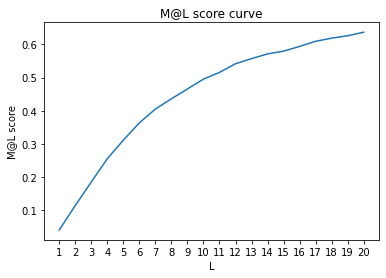

In [ ]:
plot_M_at_ks(bm25_predict, target_ids)

In [ ]:
MAP(bm25_predict, target_ids)

0.16464266568250158

In [ ]:
MRR(bm25_predict, target_ids)

0.16464266568250158

In [ ]:
rouge_mat_bm = rouge_topM(bm25_predict, target_ids, full_corpus)

100%|██████████| 842/842 [09:39<00:00,  1.45it/s]


In [ ]:
ranking_mat_bm = rouge2ranking(rouge_mat_bm)

In [ ]:
ndcg_list_bm = NDCG(ranking_mat_bm)

In [ ]:
np.mean(ndcg_list_bm)

0.41076325459989144

###sent2vec eval

In [ ]:
M_at_k(sent2vec_predict, target_ids, k=2)

0.11520190023752969

M@20 score: 0.5095011876484561


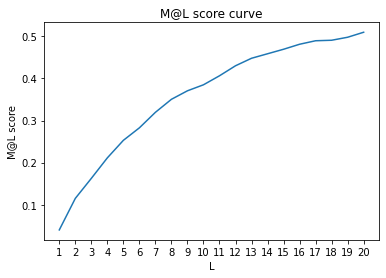

In [ ]:
plot_M_at_ks(sent2vec_predict, target_ids)

In [ ]:
MAP(sent2vec_predict, target_ids)

0.14145070561580342

In [ ]:
MRR(sent2vec_predict, target_ids)

0.14145070561580342

In [ ]:
rouge_mat_sent = rouge_topM(sent2vec_predict, target_ids, full_corpus)

100%|██████████| 842/842 [08:02<00:00,  1.75it/s]


In [ ]:
ranking_mat_sent = rouge2ranking(rouge_mat_sent)

In [ ]:
ndcg_list_sent = NDCG(ranking_mat_sent)

In [ ]:
np.mean(ndcg_list_sent)

0.3774010772356472

###hybrid eval

In [ ]:
M_at_k(hybrid_or_predict, target_ids, k=2)

0.1187648456057007

M@20 score: 0.502375296912114


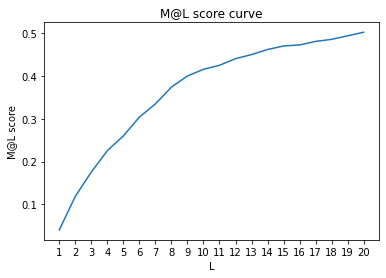

In [ ]:
plot_M_at_ks(hybrid_or_predict, target_ids)

In [ ]:
MAP(hybrid_or_predict, target_ids)

0.1450531447304941

In [ ]:
MRR(hybrid_or_predict, target_ids)

0.1450531447304941

In [ ]:
rouge_mat_hy = rouge_topM(hybrid_or_predict, target_ids, full_corpus)

100%|██████████| 842/842 [07:40<00:00,  1.83it/s]


In [ ]:
ranking_mat_hy = rouge2ranking(rouge_mat_hy)

In [ ]:
ndcg_list_hy = NDCG(ranking_mat_hy)

In [ ]:
np.mean(ndcg_list_hy)

0.39197608334893697

#Within

In [ ]:
def search_per_article(merge_res,merge_dis,merge_par):
  assert len(merge_res) == len(merge_dis)
  assert len(merge_dis) == len(merge_par)
  
  engine = SearchEngine()
  bm25_preds = []
  sent2vec_preds = []
  hybrid_preds = []
  
  total_cnt = 0
  prev_iter_cnt = []

  for a_id in range(len(merge_res)):
    cnt_res = 0
    cnt_dis = 0
    cnt1 = 0
    cnt2 = 0

    full_corpus = []
    ds = []
    discussions = []
    for d_id in range(len(merge_res[a_id]['res'])):
      for r_id in range( min(len(merge_res[a_id]['res']), 3) ):
        instance = [cnt_res, merge_res[a_id]['res'][d_id][r_id], cnt_dis]
        ds.append(instance)
        cnt_res += 1
      cnt_dis += 1

    for d_id in range(len(merge_dis[a_id]['disc'])):
      instance = [cnt1, merge_dis[a_id]['disc'][d_id]]
      discussions.append(instance)
      cnt1 += 1

    for par in merge_par[a_id]['par']:
      instance = [cnt2, par]
      full_corpus.append(instance)
      cnt2 += 1

    prev_iter_cnt.append(total_cnt)
    total_cnt += len(merge_par[a_id]['par'])

    full_corpus = np.array(full_corpus)
    ds = np.array(ds)
    discussions = np.array(discussions)
    ds,discussions,full_corpus = engine.preprocess(ds,discussions,full_corpus)
    bm25_predict = engine.bm25_predict(ds, full_corpus).astype('int')
    normalized_embeddings = engine.normalized_embeddings(model, full_corpus[:,1])
    sent2vec_predict = engine.sent2vec_predict(model, normalized_embeddings, ds, full_corpus).astype('int')
    inverted_index = engine.compute_inverted_index(full_corpus)
    hybrid_or_predict = engine.hybrid_search(inverted_index, normalized_embeddings, ds, full_corpus)

    bm25_preds.append(bm25_predict)
    sent2vec_preds.append(sent2vec_predict)
    hybrid_preds.append(hybrid_or_predict)

  return prev_iter_cnt, bm25_preds, sent2vec_preds, hybrid_preds


##Retrieval

In [ ]:
prev_iter_cnt, bm25_preds, sent2vec_preds, hybrid_preds = search_per_article(merge_res=merge_res,merge_dis=merge_dis,merge_par=merge_par)

100%|██████████| 9/9 [00:00<00:00, 269.01it/s]


In [ ]:
bm25_preds_within = []
for i, arr in enumerate(bm25_preds):
  for lst in arr:
    while len(lst) < 21:
      lst = np.append(lst, -1)
    tmp = []
    for element in lst:
      if element > 0:
        tmp.append(element+prev_iter_cnt[i])
      else:
        tmp.append(element)
    # tmp = lst + prev_iter_cnt[i]
    bm25_preds_within.append(np.asarray(tmp))
bm25_preds_within = np.array(bm25_preds_within)

sent2vec_preds_within = []
for i, arr in enumerate(sent2vec_preds):
  for lst in arr:
    while len(lst) < 21:
      lst = np.append(lst, -1)
    tmp = []
    for element in lst:
      if element > 0:
        tmp.append(element+prev_iter_cnt[i])
      else:
        tmp.append(element)
    sent2vec_preds_within.append(np.asarray(tmp))
sent2vec_preds_within = np.array(sent2vec_preds_within)

hybrid_preds_within = []
for i, arr in enumerate(hybrid_preds):
  for lst in arr:
    while len(lst) < 21:
      lst = np.append(lst, -1)
    tmp = []
    for element in lst:
      if element > 0:
        tmp.append(element+prev_iter_cnt[i])
      else:
        tmp.append(element)
    hybrid_preds_within.append(np.asarray(tmp))
hybrid_preds_within = np.array(hybrid_preds_within)

In [ ]:
bm25_preds_within

array([[  32,    2,   16, ...,   62,   20,   70],
       [  34,   29,   27, ...,   68,   14,   23],
       [  46,   28,   42, ...,   14,   67,   51],
       ...,
       [2919, 2934, 2933, ..., 2921, 2925, 2916],
       [2912, 2935, 2934, ..., 2908, 2921,    0],
       [2918, 2908, 2912, ..., 2929, 2923, 2935]])

In [ ]:
sent2vec_preds_within

array([[  32,   16,    2, ...,   28,   42,   24],
       [  34,   29,   27, ...,   18,   14,   61],
       [  46,   28,   45, ...,   20,   16,    8],
       ...,
       [2919, 2912, 2917, ..., 2911, 2921, 2914],
       [2912,    0, 2915, ..., 2908, 2929, 2909],
       [2918, 2912, 2915, ..., 2932, 2935, 2909]])

In [ ]:
hybrid_preds_within

array([[  32,   -1,   -1, ...,   -1,   -1,   -1],
       [  34,   -1,   -1, ...,   -1,   -1,   -1],
       [  46,   42,   -1, ...,   -1,   -1,   -1],
       ...,
       [2919, 2934,   -1, ...,   -1,   -1,   -1],
       [2912, 2935, 2917, ...,   -1,   -1,   -1],
       [2918, 2912, 2908, ...,   -1,   -1,   -1]])

##Evaluation

### bm25 eval

In [ ]:
M_at_k(bm25_preds_within, target_ids, k=2)

0.12826603325415678

M@20 score: 0.9002375296912114


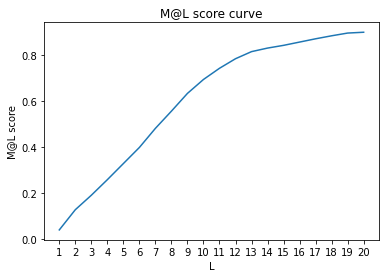

In [ ]:
plot_M_at_ks(bm25_preds_within, target_ids)

In [ ]:
MAP(bm25_preds_within, target_ids)

0.19982603145930547

In [ ]:
MRR(bm25_preds_within, target_ids)

0.19982603145930547

In [ ]:
rouge_mat_bm25_within = rouge_topM(bm25_preds_within, target_ids, full_corpus)

100%|██████████| 842/842 [07:20<00:00,  1.91it/s]


In [ ]:
ranking_mat_bm25_within = rouge2ranking(rouge_mat_bm25_within)

In [ ]:
ndcg_list_bm25_within = NDCG(ranking_mat_bm25_within)

In [ ]:
np.mean(ndcg_list_bm25_within)

0.47420459404380266

###sent2vec eval

In [ ]:
M_at_k(sent2vec_preds_within, target_ids, k=2)

0.12707838479809977

M@20 score: 0.8966745843230404


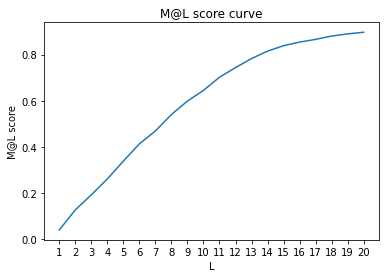

In [ ]:
plot_M_at_ks(sent2vec_preds_within, target_ids)

In [ ]:
MAP(sent2vec_preds_within, target_ids)

0.19768606128927824

In [ ]:
MRR(sent2vec_preds_within, target_ids)

0.19768606128927824

In [ ]:
rouge_mat_sent_within = rouge_topM(sent2vec_preds_within, target_ids, full_corpus)

100%|██████████| 842/842 [06:59<00:00,  2.01it/s]


In [ ]:
ranking_mat_sent_within = rouge2ranking(rouge_mat_sent_within)

In [ ]:
ndcg_list_sent_within = NDCG(ranking_mat_sent_within)

In [ ]:
np.mean(ndcg_list_sent_within)

0.4704408932792719

###hybrid eval

In [ ]:
M_at_k(hybrid_preds_within, target_ids, k=2)

0.09144893111638955

M@20 score: 0.14014251781472684


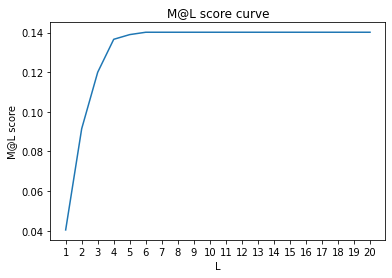

In [ ]:
plot_M_at_ks(hybrid_preds_within, target_ids)

In [ ]:
MAP(hybrid_preds_within, target_ids)

0.08024544734758511

In [ ]:
MRR(hybrid_preds_within, target_ids)

0.08024544734758511

In [ ]:
rouge_mat_hybrid_within = rouge_topM(hybrid_preds_within, target_ids, full_corpus)

100%|██████████| 842/842 [06:31<00:00,  2.15it/s]


In [ ]:
ranking_mat_hybrid_within = rouge2ranking(rouge_mat_hybrid_within)

In [ ]:
ndcg_list_hybrid_within = NDCG(ranking_mat_hybrid_within)

In [ ]:
np.mean(ndcg_list_hybrid_within)

0.38057800459609276